## An Alternative walkthrough of HW2

HW2 problem statement is as follows:

Suppose the globe tossing data (Chapter 2) had turned out to be 3 water and 11 land. Construct the posterior distribution. Then using the posterior distribution, compute the posterior predictive distribution for the next
5 tosses of the same globe.

This may feel a little abstract. So here is an alternative framing of the same question:

* Suppose you're playing a video game where you appear in a world that has water or land tiles, and you carry a ladder. If you encounter land tiles, you just walk over them. If you encounter water tiles, you can use the ladder, but only if the ladder is long enough (e.g. if you encounter 3 water tiles in a row, but your ladder is two-tiles long, you die). Longer ladders are more expensive, and so you want to maximize your chances of surviving without investing too much money.

* Now, suppose you start the game in "explore" mode that allows you to gain understanding of the world before buying the first ladder. You cross 14 tiles, of which 3 are water and 11 are land. You want to understand:

  1. What's your best guess about the proportion of land:water in this world?
  2. Suppose you bought a 4-tile long ladder, what are the chances you'd be fine? In other words, what's the chance of encountering 5 water tiles in a row?

## Frequentist solution

I want to show how one could solve this using more "traditional" approaches - hopefully it will also help connect the dots and illustrate the differences.

Conceptually, question #1 is a parameter estimation problem. Given outcomes of 0 (water) or 1 (land), estimate the expected proportion. The standard tool for that is a logistic regression! We don't have any covariates here - so we're just fitting a logistics regression with an intercept only.

In [130]:
import statsmodels.api as sm
import numpy as np

n_water = 3
n_land = 11

y = np.concatenate((np.zeros(n_water), np.ones(n_land)))

# Add a constant term to the independent variable
X = np.ones(len(y))

# Fit the logistic regression model
model = sm.Logit(y, X)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.519580
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   14
Model:                          Logit   Df Residuals:                       13
Method:                           MLE   Df Model:                            0
Date:                Wed, 28 Jan 2026   Pseudo R-squ.:               1.412e-10
Time:                        23:05:24   Log-Likelihood:                -7.2741
converged:                       True   LL-Null:                       -7.2741
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2993      0.651      1.995      0.046       0.023       2.576
==============================================================================
"""

Now, remember that logistic regression coefficients are log-odds. We need to transform them to get the actual probability of land.

In [131]:
param_value = np.exp(results.params[0]) / (np.exp(results.params[0]) + 1)

ci_lower, ci_upper = (np.exp(results.conf_int()) / (np.exp(results.conf_int()) + 1))[0]

print(
    "Probability of land: {:.3f} (95% CI: {:.3f}, {:.3f})".format(
        param_value, ci_lower, ci_upper
    )
)

Probability of land: 0.786 (95% CI: 0.506, 0.929)


Ok, so we learned that the best guess for the proportion of land in this world is 0.786, with a 95% confidence interval of [0.506, 0.929]. Not a very confident estimate! But we only have 14 observations, so that make sense.

How do we answer the other question, though? How do we estimate the probability of 5 water tiles in a row? Well, really, the only way is to invoke first principles - the logistic regression itself can't help us with that answer. 

We could say "if proportion of land is 0.786, then proportion of water is 0.214". And observing 5 water tiles in a row has a probability of $0.214^5$:

In [132]:
"Probability of 5 water tiles in a row: {:.2%}".format((1 - param_value) ** 5)

'Probability of 5 water tiles in a row: 0.05%'

Ah, but that assumes that we KNOW that the probability is exactly 0.214. But our confidence interval is very wide! What if it was the extremes of the either ends of the confidence interval?

In [133]:
print(
    "Probability of 5 water tiles in a row - lower bound: {:.2%}".format(
        (1 - ci_lower) ** 5
    )
)
print(
    "Probability of 5 water tiles in a row - upper bound: {:.2%}".format(
        (1 - ci_upper) ** 5
    )
)

Probability of 5 water tiles in a row - lower bound: 2.95%
Probability of 5 water tiles in a row - upper bound: 0.00%


Great... so maybe it's 3%. Or maybe it's 0.05%. Or maybe practically zero. Not exactly useful for decision purposes -_-. With frequentist statistics, we can't actually arrive at this answer fully. Even what we do with CI interval isn't exactly right, as CI interval doesn't tell us "with 95% probability, the true parameter is within these bounds" (go look up what CI means if you're interested as a side quest ;))

## Bayesian approach

Now, let's try the Bayesian approach. 

First, we need to pick appropriate probability distributions. Here, there are some natural choices:

* Bernoulli distribution is used to describe variables that take value of 0 or 1 with a probability of `p` of success. We can use it to model our land vs. water outcomes.

* Bernoulli distribution works for single draws only, though, and it can be seen as a special case of Binomial distribution, which is used to describe the probability of $k$ successes out of $n$ trials, where each trial has probability of $p$. We can use it instead to directly work with "out of 14 trials, 11 were land" information vs. thinking about individual trials.

* Beta distribution is used to describe proportions (i.e. continuous variables take values between 0 and 1), parameterized by two parameters, usually referred to as $\alpha, \beta$ (similar to how a Normal distribution is parameterized by mean and standard deviation).

You may ask - how do I know this? Well, that's sort of a prerequisite to Bayesian statistics (some familiarity with what sort of distributions exist). The good news that there isn't a ton of them you need to learn about - key 5-10 distributions are more than enough to design most models.

You may not be familiar with Beta distribution - here's how it looks. Higher $\alpha$ values push the distribution towards 1, while higher $\beta$ values push it towards zero.

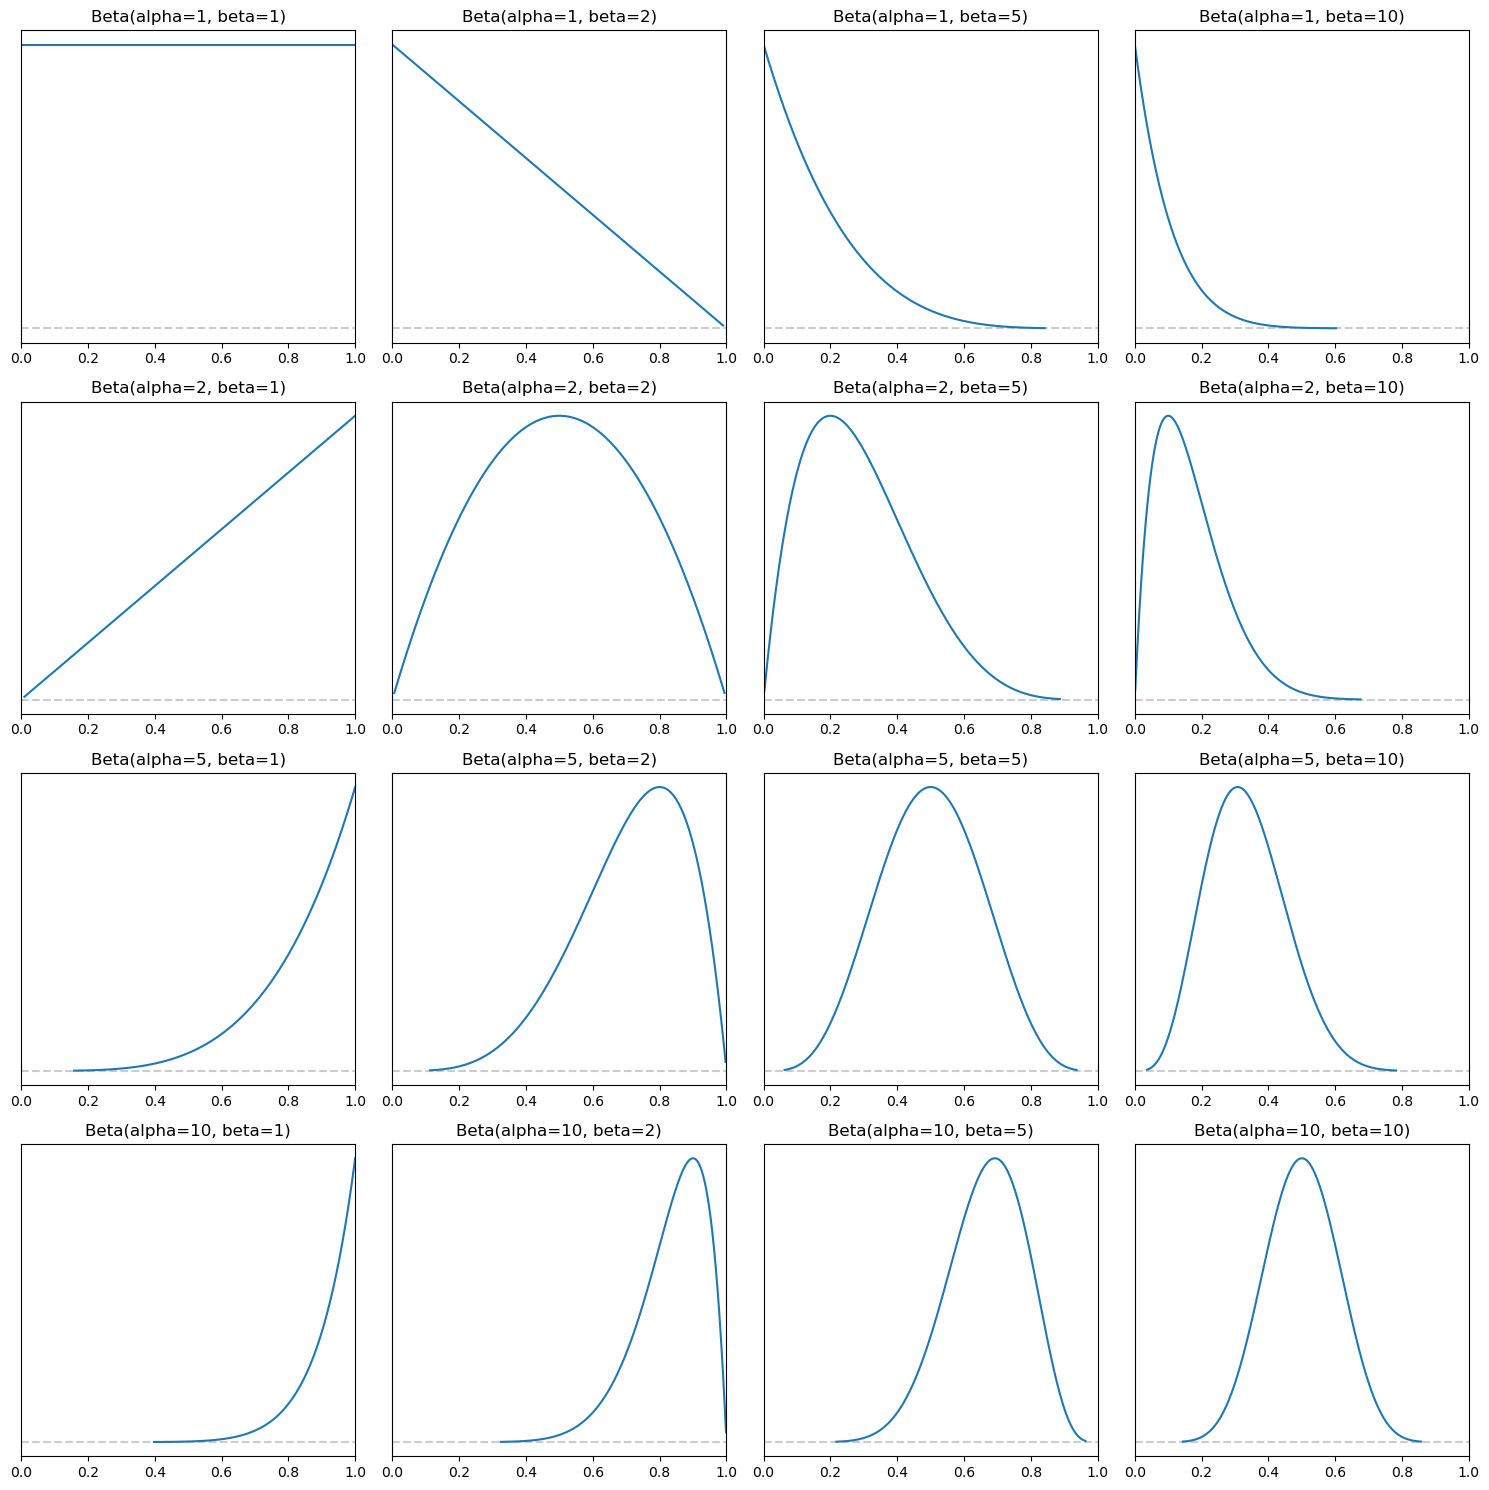

In [134]:
import preliz as pz
from matplotlib import pyplot as plt
import itertools

alpha_values = [1, 2, 5, 10]
beta_values = [1, 2, 5, 10]

combinations = list(itertools.product(alpha_values, beta_values))

# Plot all combinations
fig, axes = plt.subplots(len(alpha_values), len(beta_values), figsize=(15, 15))

for i, (alpha, beta) in enumerate(combinations):
    ax = axes[i // len(beta_values), i % len(beta_values)]
    pz.distributions.Beta(alpha=alpha, beta=beta).plot_pdf(ax=ax)
    ax.set_title(f"Beta(alpha={alpha}, beta={beta})")
    ax.set_xlim(0, 1)
    ax.legend().set_visible(False)

plt.tight_layout()
plt.show()


Let's assume we have never played this game before. So to start with, we have no idea what the land:water ratio is. In that case, one natural choice may be to pick distribution Beta(1,1) which gives equal probability to each proportion.

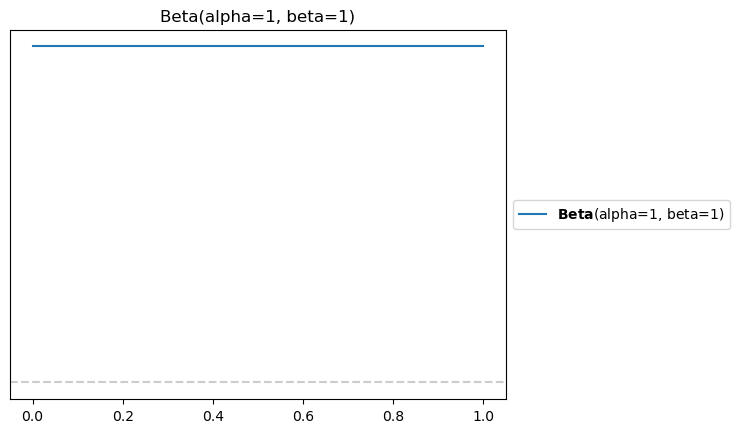

In [135]:
ax = pz.distributions.Beta(alpha=1, beta=1).plot_pdf()
ax.set_title("Beta(alpha=1, beta=1)")
plt.show()

Now, how do we get to posterior distribution? Well, it turns out that the there is a mathematical relationship that we can leverage in this case:
 * if the prior distribution is Beta distribution
 * and observed data follows Binomial distribution
 * Then the posterior distribution happens to be Beta distribution, too!


This is known as "conjugate distribution pair". Wikipedia has a table of [distribution pairs](https://en.wikipedia.org/wiki/Conjugate_prior) that are conjugate. That is not always the case - but in this case we're lucky, because it gives us the following closed-form relationship between prior and posterior:

* if prior distribution is $B(\alpha, \beta)$
* And we have observed $k$ successes out of $n$ trials
* Then the posterior distribution is $B(\alpha + k, \beta + n - k)$

So, in this case:

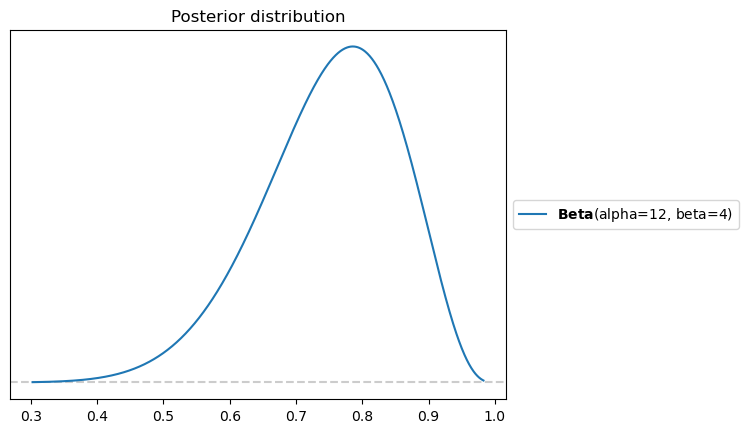

In [136]:
alpha = 1
beta = 1

n = len(y)
k = sum(y)

posterior_alpha = alpha + k
posterior_beta = beta + n - k

posterior_distribution = pz.distributions.Beta(
    alpha=posterior_alpha, beta=posterior_beta
)
ax = posterior_distribution.plot_pdf()
ax.set_title("Posterior distribution")
plt.show()


Cool, we learned the posterior distribution of the proportion of land:water. We could ask: based on this distribution, what's the expected proportion? In other words, what's the mean of that distribution?

In [137]:
print("Expected proportion of land: {:.3f}".format(posterior_distribution.mean()))

Expected proportion of land: 0.750


Pretty close to the frequentist estimate! They are a little different, because logistic regression uses a sigmoid function under the hood and that's not the same mathematical expression as it's under the hood of Beta distribution.

Similarly to logistic regression, we can ask: what's the interval of proportions that cover 95% of the density of this distribution. That's known as a credible interval - and it does have a direct probability interpretation ("there's a 95% chance that the proportion is in this range")

We get bounds of 0.54 - 0.94. Again, pretty wide bounds! And quite similar to logistic regression intervals.

In [66]:
posterior_distribution.hdi(0.95)

(0.54, 0.94)

Finally, let's answer the question of how likely we are to survive with a 4-tile ladder. Unlike the frequentist approach, we won't do it with a fixed proportion like we had to do it above. Here, we'll do it in two steps:
 - Draw the proportion from the posterior distribution. This will capture the uncertainty that we do not know what the proportion actually is.
 - Then, use the proportion to draw successes, and observe how many of them we get. Given we're asking the question "how many successes out of 5 we're getting", we will use Binomial distribution with n=5.

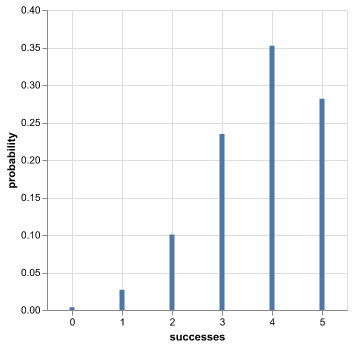

Probability of encountering 5 water tiles in a row: 0.36%


In [167]:
import polars as pl
import altair as alt

alt.renderers.enable("png")

n_draws = 10_000_000

# Draw the proportion from the posterior distribution
proportions = posterior_distribution.rvs(n_draws)

# Use the proportion to draw successes, and observe how many of them we get
successes = pz.distributions.Binomial(n=5, p=proportions).rvs(n_draws)

grouped_successes = (
    pl.DataFrame({"successes": successes})
    .group_by("successes")
    .agg(pl.len().alias("count"))
    .with_columns((pl.col("count") / pl.col("count").sum()).alias("probability"))
)
grouped_successes.plot.bar(x="successes", y="probability").display()

print(
    "Probability of encountering 5 water tiles in a row: {:.2%}".format(
        grouped_successes.filter(pl.col("successes") == 0).select("probability").item()
    )
)


And we got an answer that takes into account the uncertainty of our estimate of the proportion of land:water. We can increase the number of draws to get more confident about the answer, but we no longer need to choose between using expected proportion vs. upper/lower bounds.

## Bonus: domain knowledge

Suppose you played this game many times before and you know that usually the proportion of land:water is 0.8 and it's very unlikely to be less than 0.4. You could encode it in your prior! For example like this:

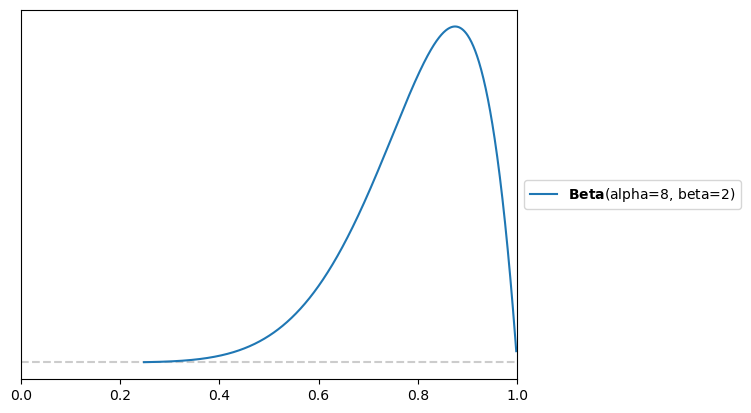

In [168]:
prior_distribution = pz.distributions.Beta(alpha=8, beta=2)
ax = prior_distribution.plot_pdf()
ax.set_xlim(0, 1)
plt.show()

Now your posterior distribution will look a little different:

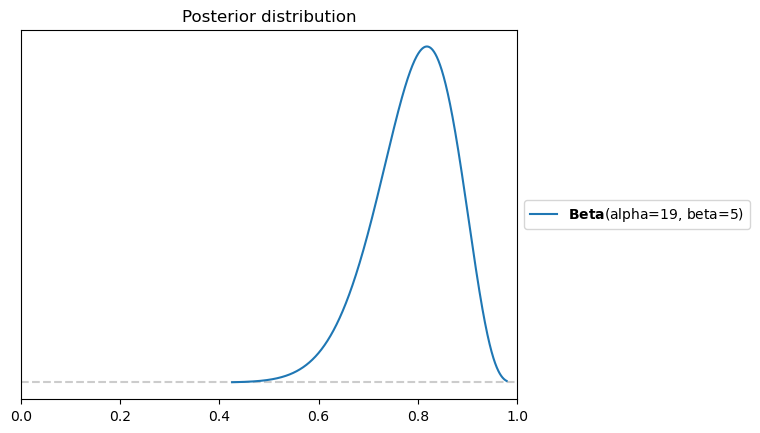

In [169]:
alpha = 8
beta = 2

n = sum(y)
k = len(y) - n

posterior_alpha = alpha + n
posterior_beta = beta + k

posterior_distribution = pz.distributions.Beta(
    alpha=posterior_alpha, beta=posterior_beta
)
ax = posterior_distribution.plot_pdf()
ax.set_title("Posterior distribution")
ax.set_xlim(0, 1)
plt.show()


Let's estimate all the values of interest again:

In [170]:
print("Expected proportion of land: {:.3f}".format(posterior_distribution.mean()))

Expected proportion of land: 0.792


In [171]:
posterior_distribution.hdi(0.95)

(0.63, 0.94)

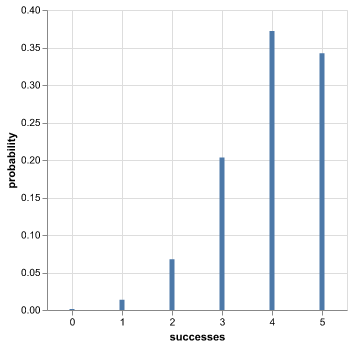

Probability of encountering 5 water tiles in a row: 0.13%


In [172]:
import polars as pl
import altair as alt

alt.renderers.enable("png")

n_draws = 10_000_000

# Draw the proportion from the posterior distribution
proportions = posterior_distribution.rvs(n_draws)

# Use the proportion to draw successes, and observe how many of them we get
successes = pz.distributions.Binomial(n=5, p=proportions).rvs(n_draws)

grouped_successes = (
    pl.DataFrame({"successes": successes})
    .group_by("successes")
    .agg(pl.len().alias("count"))
    .with_columns((pl.col("count") / pl.col("count").sum()).alias("probability"))
)
grouped_successes.plot.bar(x="successes", y="probability").display()

print(
    "Probability of encountering 5 water tiles in a row: {:.2%}".format(
        grouped_successes.filter(pl.col("successes") == 0).select("probability").item()
    )
)


With this knowledge, our final estimate of encountering 5 water tiles in a row is 3x lower! 